<center>
    <font size="6"><b>Introduction to Time Series Prediction</b></font>
    <br>
    <font size="3">(draft version)</font>
</center>

<br>

<center>
    <font size="3"><b>Piotr Lipiński</b></font>
    <br>
    Computational Intelligence Research Group, Institute of Computer Science, University of Wroclaw, Poland
    <br>
    lipinski@cs.uni.wroc.pl
</center>

### Abstract:

This notebook presents an introduction to time series prediction and illustrates the problem on the Airline Passengers dataset.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model

%matplotlib inline

## 1. Time Series Data

In [38]:
df = pd.read_csv('Dane/Metro_Interstate_Traffic_Volume.csv')["traffic_volume"][:1200]
df = pd.DataFrame(df)
df

traffic_volume
0               5545
1               4516
2               4767
3               5026
4               4918
...              ...
1195            2044
1196            1841
1197             575
1198             325
1199             294

[1200 rows x 1 columns]

<Figure size 864x288 with 0 Axes>

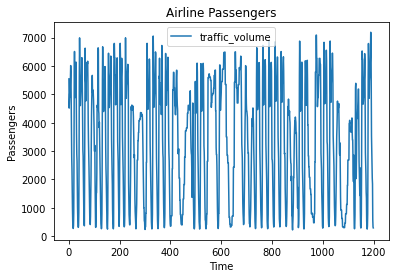

In [39]:
plt.figure(figsize=(12,4))
df.plot()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.show()

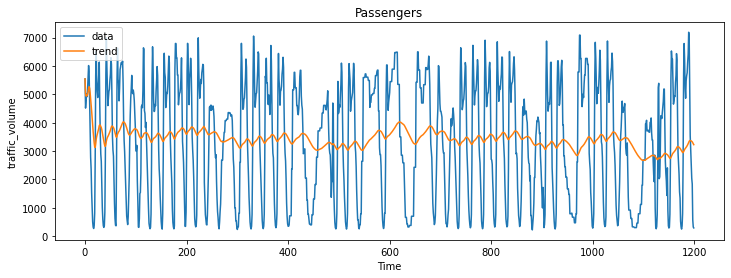

In [40]:
df['trend'] = df.ewm(halflife=60).mean()

plt.figure(figsize=(12,4))
df['traffic_volume'].plot(label='data')
df['trend'].plot(label='trend')
plt.xlabel('Time')
plt.ylabel('traffic_volume')
plt.title('Passengers')
plt.legend(loc='upper left')
plt.show()

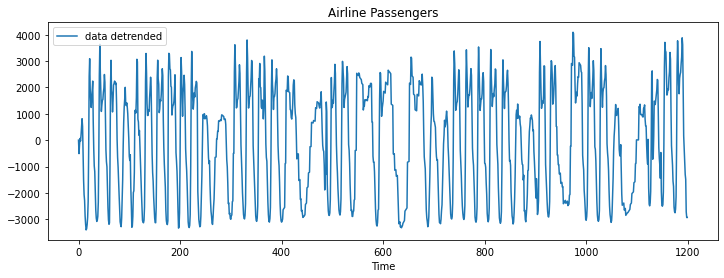

In [41]:
df['detrended'] = df['traffic_volume'] - df['trend']

plt.figure(figsize=(12,4))
df['detrended'].plot(label='data detrended')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

0      473.006019
1      682.892054
2      717.455399
3      663.170640
4      650.035076
5      641.454052
6      589.038572
7      183.200600
8     -226.345213
9     -488.676557
10    -632.004798
11    -654.452917
12    -815.361292
13    -995.302622
14   -1022.099828
15   -1032.123254
16   -1040.223135
17    -750.051744
18    -319.364306
19     177.993944
20     644.309381
21     664.374335
22     510.206904
23     347.477234
Name: seasonality, dtype: float64

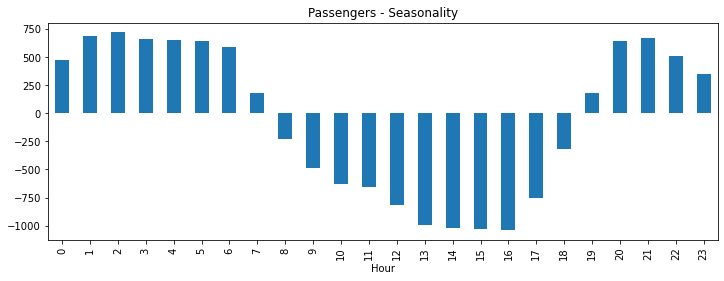

In [42]:
df_seasonality = df['detrended'].groupby(df.index%24).mean().rename('seasonality')
display(df_seasonality)

plt.figure(figsize=(12,4))
df_seasonality.plot(kind='bar')
plt.xlabel('Hour')
plt.ylabel('')
plt.title('Passengers - Seasonality')
plt.show()

In [43]:
df = df.join(df_seasonality, how='left', on=(df.index%24))

plt.figure(figsize=(12,4))
df['seasonality'].plot(label='seasonality')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

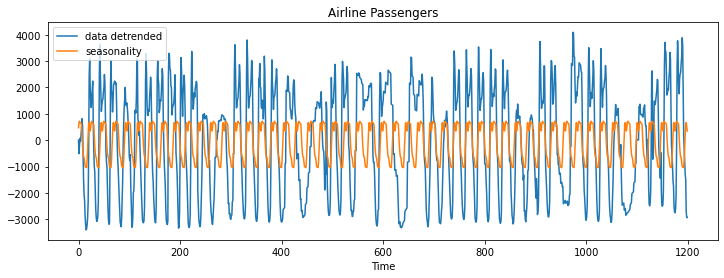

In [44]:
df['preprocessed0'] = df['detrended'] - df['seasonality']

plt.figure(figsize=(12,4))
df['detrended'].plot(label='data detrended')
df['seasonality'].plot(label='seasonality')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12,4))
df['preprocessed0'].plot(label='preprocessed data')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

In [45]:
df["preprocessed"]=df["preprocessed0"]-df['preprocessed0'].shift(1).fillna(0.0)
df['wariancjaKrocz'] = df['preprocessed0'].rolling(window=24, min_periods=1).var()
df['wariancjaKrocz2'] = df['preprocessed'].rolling(window=24, min_periods=1).var()

In [46]:
plt.plot(df["preprocessed0"], label="preprocesed0")
plt.plot(df["preprocessed"], label="diff")
plt.legend()

In [47]:
plt.plot(df["wariancjaKrocz"], label="preprocesed0")
plt.plot(df["wariancjaKrocz2"], label="diff")
plt.legend()

## 2. Approach 1: Prediction by the global mean

In [48]:
df['prediction_raw'] = df['preprocessed'].mean()

plt.figure(figsize=(12,4))
df['preprocessed'].plot(label='preprocessed data')
df['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Passengers')
plt.legend(loc='upper left')
plt.show()

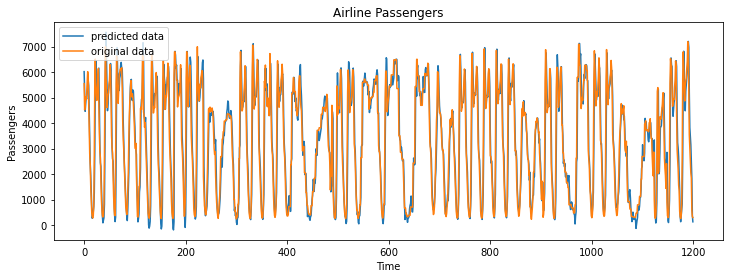

In [49]:
plt.figure(figsize=(12,4))
(df['prediction_raw'] +df['preprocessed0'].shift(1).fillna(0.0)+ df['seasonality']).plot(label='prediction with seasonality')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12,4))
((df['prediction_raw'] + df['preprocessed0'].shift(1).fillna(0.0)+df['seasonality']) + df['trend']).plot(label='predicted data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

df['prediction'] = (df['prediction_raw'] +df['preprocessed0'].shift(1).fillna(0.0)+ df['seasonality']) + df['trend']

plt.figure(figsize=(12,4))
df['prediction'].plot(label='predicted data')
df['traffic_volume'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

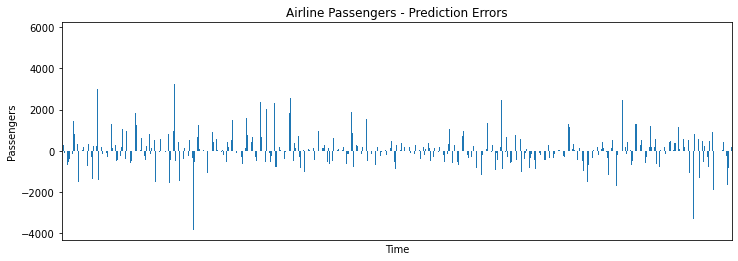

In [50]:
plt.figure(figsize=(12,4))
(df['traffic_volume'] - df['prediction']).plot(kind='bar')
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers - Prediction Errors')
plt.show()

In [51]:
plt.figure(figsize=(12,4))
((df['traffic_volume'] - df['prediction']) / df['traffic_volume']).plot(kind='bar')
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Passengers [in %]')
plt.title('Airline Passengers - Prediction Percentage Errors')
plt.show()

In [52]:
print('MSE: %0.4f' % ((df['traffic_volume'] - df['prediction'])**2).mean())

MSE: 608704.3534


In [53]:
print('MAE: %0.4f' % (df['traffic_volume'] - df['prediction']).abs().mean())

MAE: 512.9281


In [54]:
print('MAPE: %0.4f' % ((df['traffic_volume'] - df['prediction']) / df['traffic_volume']).abs().mean())

MAPE: 0.2437


## 3. Approach 2: Prediction by the previous value

In [55]:
df['prediction_raw'] = df['preprocessed'].shift(1).fillna(0.0)

plt.figure(figsize=(12,4))
df['preprocessed'].plot(label='preprocessed data')
df['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

In [56]:
df['prediction'] = (df['prediction_raw'] + df['preprocessed0'].shift(1).fillna(0.0)+df['seasonality']) + df['trend']

plt.figure(figsize=(12,4))
df['prediction'].plot(label='predicted data')
df['traffic_volume'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((df['traffic_volume'] - df['prediction'])**2).mean())
print('MAE: %0.4f' % (df['traffic_volume'] - df['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df['traffic_volume'] - df['prediction']) / df['traffic_volume']).abs().mean())

MSE: 662470.6008
MAE: 547.0917
MAPE: 0.2601


## 4. Approach 3: Prediction by the moving average

In [57]:
df['prediction_raw'] = df['preprocessed'].shift(1).fillna(0.0).rolling(window=3, min_periods=1).mean()
# df['prediction_raw'] = df['preprocessed'].shift(1).fillna(0.0).rolling(window=12, min_periods=1).mean()

plt.figure(figsize=(12,4))
df['preprocessed'].plot(label='preprocessed data')
df['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

In [58]:
df['prediction'] = (df['prediction_raw'] + df['preprocessed0'].shift(1).fillna(0.0)+df['seasonality']) + df['trend']

plt.figure(figsize=(12,4))
df['prediction'].plot(label='predicted data')
df['traffic_volume'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((df['traffic_volume'] - df['prediction'])**2).mean())
print('MAE: %0.4f' % (df['traffic_volume'] - df['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df['traffic_volume'] - df['prediction']) / df['traffic_volume']).abs().mean())

MSE: 752158.4614
MAE: 599.8847
MAPE: 0.2961


## 5. Approach 4: Prediction by the linear regression

In [59]:
reg = linear_model.LinearRegression()

X = df['preprocessed'].shift(1).values[1:].reshape(-1, 1)
y = df['preprocessed'].values[1:]

reg.fit(X, y)

y_predicted = np.zeros(len(df))
y_predicted[1:] = reg.predict(X)

In [60]:
plt.figure(figsize=(6,6))
plt.plot(X[:, 0], y, 'o')
plt.plot([X.min(), X.max()], [reg.coef_[0] * X.min() + reg.intercept_, reg.coef_[0] * X.max() + reg.intercept_], '-')
plt.xlabel('$X_{t-1}$')
plt.ylabel('$X_t$')
plt.title('Linear Regression')
plt.show()

In [61]:
df['prediction_raw'] = y_predicted

plt.figure(figsize=(12,4))
df['preprocessed'].plot(label='preprocessed data')
df['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

In [62]:
df['prediction'] = (df['prediction_raw'] + df['preprocessed0'].shift(1).fillna(0.0)+df['seasonality']) + df['trend']

plt.figure(figsize=(12,4))
df['prediction'].plot(label='predicted data')
df['traffic_volume'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((df['traffic_volume'] - df['prediction'])**2).mean())
print('MAE: %0.4f' % (df['traffic_volume'] - df['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df['traffic_volume'] - df['prediction']) / df['traffic_volume']).abs().mean())

MSE: 482230.9426
MAE: 457.9988
MAPE: 0.2111


## 6. Approach 4a: Prediction by the multidimensional linear regression

In [63]:
def make_prediction_with_linear_regression(df, y_predicted):
    df['prediction_raw'] = y_predicted

    plt.figure(figsize=(12,4))
    df['preprocessed'].plot(label='preprocessed data')
    df['prediction_raw'].plot(label='raw prediction')
    plt.xlabel('Time')
    plt.ylabel('')
    plt.title('Airline Passengers')
    plt.legend(loc='upper left')
    plt.show()

    df['prediction'] = (df['prediction_raw'] + df['preprocessed0'].shift(1).fillna(0.0)+df['seasonality']) + df['trend']

    plt.figure(figsize=(12,4))
    df['prediction'].plot(label='predicted data')
    df['traffic_volume'].plot(label='original data')
    plt.xlabel('Time')
    plt.ylabel('Passengers')
    plt.title('Passengers')
    plt.legend(loc='upper left')
    plt.show()

    print('MSE: %0.4f' % ((df['traffic_volume'] - df['prediction'])**2).mean())
    print('MAE: %0.4f' % (df['traffic_volume'] - df['prediction']).abs().mean())
    print('MAPE: %0.4f' % ((df['traffic_volume'] - df['prediction']) / df['traffic_volume']).abs().mean())

### 6.1. Prediction by the linear regression on the two previous values

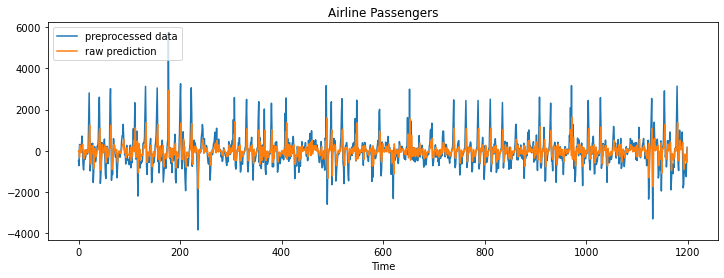

MSE: 471800.3956
MAE: 456.9916
MAPE: 0.2113


In [64]:
reg = linear_model.LinearRegression()

X = np.vstack([
    df['preprocessed'].shift(1).values[2:],
    df['preprocessed'].shift(2).values[2:]
]).T
y = df['preprocessed'].values[2:]

reg.fit(X, y)

y_predicted = np.zeros(len(df))
y_predicted[2:] = reg.predict(X)

make_prediction_with_linear_regression(df, y_predicted)

### 6.2. Prediction by the linear regression on the three previous values

In [31]:
reg = linear_model.LinearRegression()

X = np.vstack([
    df['preprocessed'].shift(1).values[3:],
    df['preprocessed'].shift(2).values[3:],
    df['preprocessed'].shift(3).values[3:]
]).T
y = df['preprocessed'].values[3:]

reg.fit(X, y)

y_predicted = np.zeros(len(df))
y_predicted[3:] = reg.predict(X)

make_prediction_with_linear_regression(df, y_predicted)

MSE: 472549.6013
MAE: 457.1591
MAPE: 0.2119


### 6.3. Autocorrelation

In [32]:
np.corrcoef(df['preprocessed'][1:], df['preprocessed'].shift(1)[1:])

array([[1.       , 0.4562683],
       [0.4562683, 1.       ]])

In [33]:
np.corrcoef(df['preprocessed'][2:], df['preprocessed'].shift(2)[2:])

array([[1.        , 0.09060556],
       [0.09060556, 1.        ]])

In [34]:
np.corrcoef(df['preprocessed'][3:], df['preprocessed'].shift(3)[3:])

array([[ 1.        , -0.06532372],
       [-0.06532372,  1.        ]])

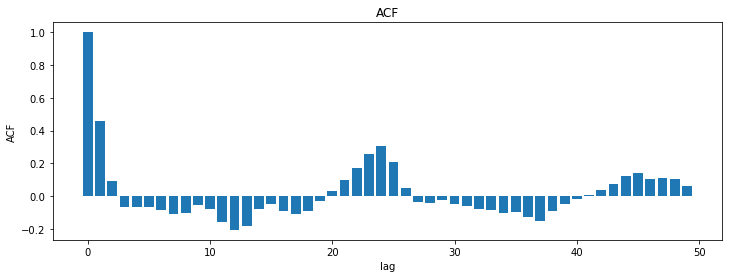

In [35]:
acf = np.zeros(50)
for lag in range(len(acf)):
    acf[lag] = np.corrcoef(df['preprocessed'][lag:], df['preprocessed'].shift(lag)[lag:])[0, 1]

plt.figure(figsize=(12,4))
plt.bar(range(len(acf)), acf)
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('ACF')
plt.show()

### 6.4. Prediction by the linear regression on the 15 previous values

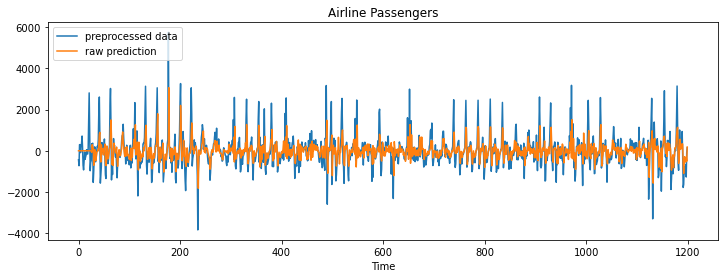

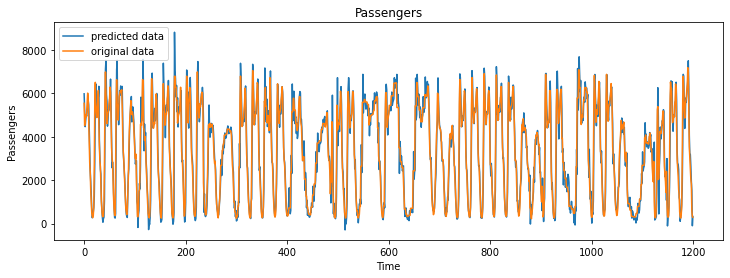

MSE: 453693.8468
MAE: 448.7841
MAPE: 0.2110


In [36]:
reg = linear_model.LinearRegression()

X = np.vstack([df['preprocessed'].shift(lag).values[26:] for lag in [1,2,24]]).T
y = df['preprocessed'].values[26:]

reg.fit(X, y)

y_predicted = np.zeros(len(df))
y_predicted[26:] = reg.predict(X)

make_prediction_with_linear_regression(df, y_predicted)

## 7. Remarks

- split the dataset into the train and the test part and repeat the experiments with learning the model on the train dataset and testing on the test dataset for a more reliable validation
- repeat the experiments without removing the trend and/or the seasonality
- repeat the experiments with the subtracting the trend from the original data instead of dividing them by the trend
- similarly, concerning the seasonality
- try to evaluate the trend with other methods, especially simple moving averages vs. exponential moving averages
- study the variance/standard deviation of the data in time, try to normalize it